# Subsampling results exploration

Quick helpers to compare subsampling specs using `results_subsampling.csv`.

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [29]:
sns.set_theme()
pd.set_option("display.max_columns", 30)

root = Path(r"C:\Users\geryatejina\dev\minspecs_eddy\subsampling_results")
res_path = root.joinpath("subsampling_5sites_full_period.csv")
df = pd.read_csv(res_path)
df["label"] = df["subsample_label"].fillna(df["subsample_mode"]).astype(str)

print(f"Loaded {len(df)} rows | sites={df['site'].nunique()} | specs={df['label'].nunique()}")
display(df.head(10))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\geryatejina\\dev\\minspecs_eddy\\subsampling_results\\subsampling_5sites_full_period.csv'

In [30]:
def rank_metric(metric="random_error_CO2", top=10, site=None):
    data = df if site is None else df[df["site"] == site]
    grp = (
        data.groupby("label")
        .agg(
            mean=(metric, "mean"),
            median=(metric, "median"),
            std=(metric, "std"),
            count=(metric, "count"),
            kept_mean=("kept_fraction_mean", "mean"),
            kept_std=("kept_fraction_std", "mean"),
            kept_p10=("kept_fraction_p10", "mean"),
            kept_p50=("kept_fraction_p50", "mean"),
            kept_p90=("kept_fraction_p90", "mean"),
        )
        .sort_values("mean")
    )
    display(grp.head(top))

def _metric_with_units(metric, data):
    series = data[metric].copy()
    label = metric
    if "rel_" in metric:
        series = series * 100.0
        label = f"{metric} (%)"
    elif metric.startswith("bias_H") or metric.startswith("random_error_H") or metric.startswith("cum_bias_H") or metric.startswith("cum_random_H"):
        label = f"{metric} (W m$^{-2}$)"
    elif metric.startswith("bias_LE") or metric.startswith("random_error_LE") or metric.startswith("cum_bias_LE") or metric.startswith("cum_random_LE"):
        label = f"{metric} (W m$^{-2}$)"
    elif metric.startswith("bias_CO2") or metric.startswith("random_error_CO2") or metric.startswith("cum_bias_CO2") or metric.startswith("cum_random_CO2"):
        label = f"{metric} ()"
    return series, label

def scatter_kept_vs(metric="random_error_CO2"):
    plot_df = df.copy()
    plot_df["_y"], ylab = _metric_with_units(metric, plot_df)
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=plot_df, x="kept_fraction_mean", y="_y",
        hue="ecosystem", style="label", palette="viridis"
    )
    plt.title(f"{metric} vs kept_fraction_mean (by ecosystem)")
    plt.ylabel(ylab)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

def bars(metric="random_error_CO2"):
    plot_df = df.copy()
    plot_df["_y"], ylab = _metric_with_units(metric, plot_df)
    grp = plot_df.groupby(["label", "ecosystem"])["_y"].mean().reset_index()
    plt.figure(figsize=(10, 5))
    sns.barplot(data=grp, x="label", y="_y", hue="ecosystem", palette="viridis")
    plt.xticks(rotation=30, ha="right")
    plt.title(f"{metric} by ecosystem")
    plt.ylabel(ylab)
    plt.show()

def best_per_site(metric="random_error_CO2"):
    best = df.loc[
        df.groupby(["ecosystem", "site"])[metric].idxmin(),
        ["ecosystem", "site", "label", metric, "kept_fraction_mean", "effective_fs_mean"],
    ]
    display(best.sort_values(metric).head(20))

def kept_summary(site=None, metric="random_error_CO2"):
    data = df if site is None else df[df["site"] == site]
    summary = (
        data.groupby("label")
        .agg(
            kept_mean=("kept_fraction_mean", "mean"),
            kept_median=("kept_fraction_mean", "median"),
            kept_std=("kept_fraction_mean", "std"),
            kept_q10=("kept_fraction_mean", lambda s: s.quantile(0.10)),
            kept_q90=("kept_fraction_mean", lambda s: s.quantile(0.90)),
            eff_fs_mean=("effective_fs_mean", "mean"),
            metric_mean=(metric, "mean"),
            count=("label", "count"),
        )
        .sort_values("kept_mean", ascending=False)
    )
    display(summary)

def kept_vs_metric(metric="random_error_CO2"):
    plot_df = df.copy()
    plot_df["_y"], ylab = _metric_with_units(metric, plot_df)
    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=plot_df, x="kept_fraction_mean", y="_y",
        hue="ecosystem", style="label", palette="viridis"
    )
    plt.title(f"{metric} vs kept_fraction_mean (by ecosystem)")
    plt.ylabel(ylab)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

# Bias views (mean +/- sd per label)
def bias_bar(metric="bias_CO2", site=None):
    data = df if site is None else df[df["site"] == site]
    plot_df = data.copy()
    plot_df["_y"], ylab = _metric_with_units(metric, plot_df)
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=plot_df, x="label", y="_y",
        estimator="mean", errorbar="sd",
        hue="ecosystem", palette="viridis"
    )
    plt.xticks(rotation=30, ha="right")
    plt.title(f"{metric} by label" + ("" if site is None else f" ({site})"))
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.show()

def ogive_distribution():
    og = df[df["label"].str.contains("ogive", case=False)]
    if og.empty:
        print("No ogive rows found.")
        return
    plt.figure(figsize=(7,4))
    sns.histplot(og["kept_fraction_mean"], bins=20, kde=True)
    plt.title("Ogive kept_fraction_mean distribution")
    plt.show()

def regression_table(flux="CO2"):
    cols = [f"reg_slope_{flux}", f"reg_intercept_{flux}", f"reg_r2_{flux}",
            f"reg_slope_{flux}_day", f"reg_intercept_{flux}_day", f"reg_r2_{flux}_day",
            f"reg_slope_{flux}_night", f"reg_intercept_{flux}_night", f"reg_r2_{flux}_night"]
    agg = df.groupby(["label", "ecosystem"])[cols].mean().round(3)
    display(agg)

def regression_strip(flux="CO2"):
    to_plot = []
    for phase in ["", "_day", "_night"]:
        to_plot.append(
            df.assign(phase=phase or "all",
                      slope=df[f"reg_slope_{flux}{phase}"],
                      r2=df[f"reg_r2_{flux}{phase}"])
        )
    plot_df = pd.concat(to_plot, ignore_index=True)
    plt.figure(figsize=(10,5))
    sns.stripplot(data=plot_df, x="label", y="slope", hue="ecosystem",
                  dodge=True, jitter=0.25, alpha=0.75, palette="viridis")
    plt.xticks(rotation=30, ha="right")
    plt.title(f"Regression slope (deg vs ref) for {flux} (all/day/night)")
    plt.ylabel("slope")
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    sns.stripplot(data=plot_df, x="label", y="r2", hue="ecosystem",
                  dodge=True, jitter=0.25, alpha=0.75, palette="viridis")
    plt.xticks(rotation=30, ha="right")
    plt.title(f"Regression R² (deg vs ref) for {flux} (all/day/night)")
    plt.ylabel("R²")
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

    def rel_error_strip(metric="rel_bias_CO2", title=None):
        plot_df = df.copy()
        ylab = metric
        plt.figure(figsize=(9,5))
        sns.stripplot(data=plot_df, x="label", y=metric, hue="ecosystem",
                    dodge=True, jitter=0.25, alpha=0.75, palette="viridis")
        plt.axhline(0, color="k", lw=0.8)
        plt.xticks(rotation=30, ha="right")
        plt.ylabel(ylab)
        plt.title(title or f"{metric} by label (ecosystem-colored)")
        plt.legend(bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.show()

,kept_mean,kept_median,kept_std,kept_q10,kept_q90,eff_fs_mean,metric_mean,count
label,,,,,,,,
ogive_stop_loose,0.766255,0.724279,8.910151e-02,0.699054,0.863279,20.000000,609.244315,5
decimate_2,0.500000,0.500000,0.000000e+00,0.500000,0.500000,10.000000,3076.734324,5
diurnal_decimate_day_high_night_low,0.321515,0.319379,5.999201e-03,0.318012,0.327147,6.430299,1031.300430,5
diurnal_burst_day_high_night_low,0.203427,0.201633,4.888114e-03,0.200642,0.207999,20.000000,1196.233499,5
decimate_5,0.200000,0.200000,5.721958e-17,0.200000,0.200000,4.000000,4186.768970,5
burst_10_50,0.166674,0.166671,6.911089e-06,0.166668,0.166682,20.000000,2123.145590,5
burst_5_25,0.166671,0.166669,4.726311e-06,0.166667,0.166676,20.000000,4776.682914,5
decimate_10,0.100000,0.100000,6.206335e-17,0.100000,0.100000,2.000000,1040.783437,5
burst_10_110,0.084452,0.083346,2.481496e-03,0.083335,0.086676,20.000000,2826.851043,5


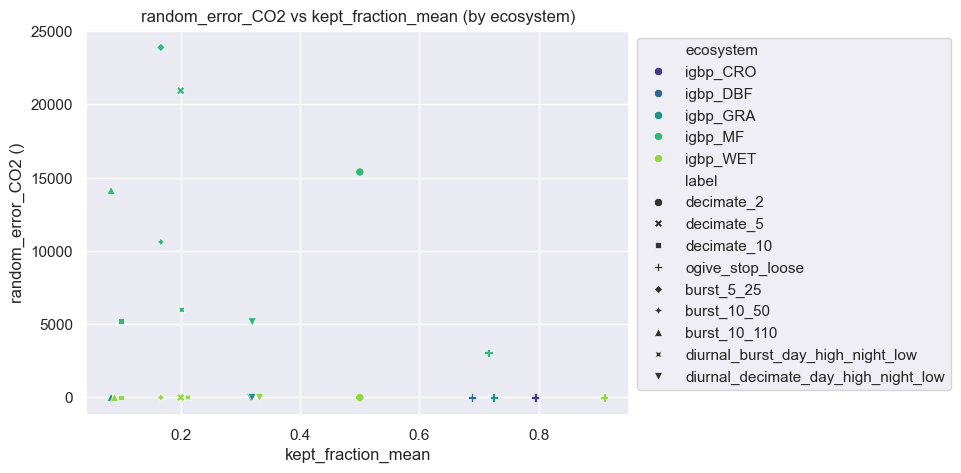

In [31]:
kept_summary(metric="random_error_CO2")
kept_vs_metric("random_error_CO2")

,mean,median,std,count,kept_mean,kept_std,kept_p10,kept_p50,kept_p90
label,,,,,,,,,
ogive_stop_loose,609.244315,0.828364,1361.026672,5,0.766255,2.578093e-01,0.373078,0.851975,1.000000
diurnal_decimate_day_high_night_low,1031.300430,0.221973,2305.664019,5,0.321515,1.987658e-01,0.100000,0.500000,0.500000
decimate_10,1040.783437,0.407491,2326.351313,5,0.100000,1.665335e-17,0.100000,0.100000,0.100000
diurnal_burst_day_high_night_low,1196.233499,1.764776,2671.322048,5,0.203427,1.446642e-01,0.042222,0.333333,0.333333
burst_10_50,2123.145590,1.669316,4744.089121,5,0.166674,4.124819e-04,0.166667,0.166667,0.166667
burst_10_110,2826.851043,2.562517,6315.981687,5,0.084452,5.189851e-04,0.084444,0.084444,0.084444
decimate_2,3076.734324,0.038611,6879.670929,5,0.500000,0.000000e+00,0.500000,0.500000,0.500000
decimate_5,4186.768970,0.176136,9361.540047,5,0.200000,3.330669e-17,0.200000,0.200000,0.200000
burst_5_25,4776.682914,1.349937,10678.285433,5,0.166671,2.679151e-04,0.166667,0.166667,0.166667


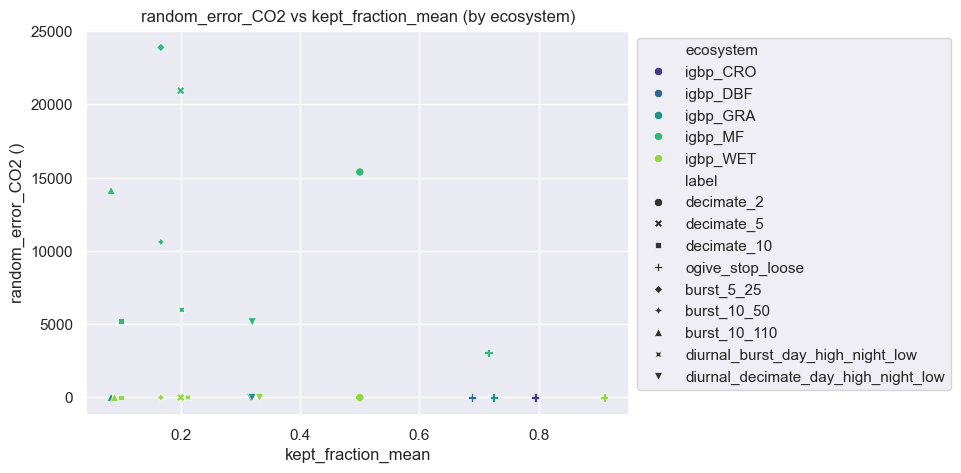

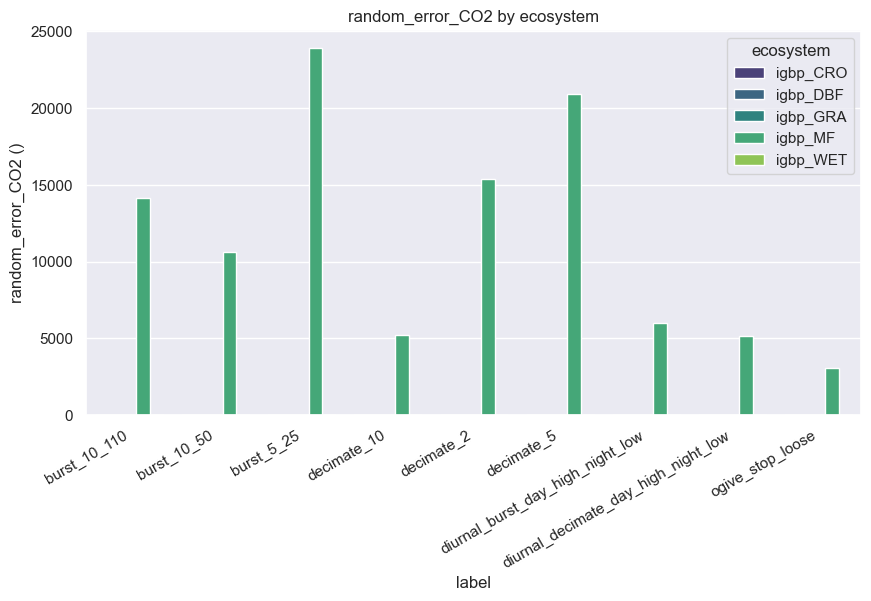

,ecosystem,site,label,random_error_CO2,kept_fraction_mean,effective_fs_mean
9,igbp_DBF,CZ-Lnz,decimate_2,0.016319,0.500000,10.0
0,igbp_CRO,BE-Lon,decimate_2,0.026135,0.500000,10.0
18,igbp_GRA,BE-Dor,decimate_2,0.038611,0.500000,10.0
39,igbp_WET,FI-Sii,ogive_stop_loose,0.088427,0.909609,20.0
30,igbp_MF,BE-Vie,ogive_stop_loose,3043.922745,0.715544,20.0


In [33]:
# Quick runs (tweak metrics as needed)
rank_metric("random_error_CO2")
scatter_kept_vs("random_error_CO2")
bars("random_error_CO2")
best_per_site("random_error_CO2")

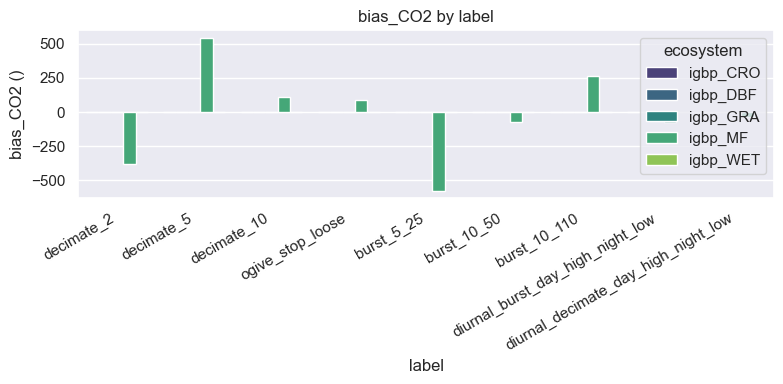

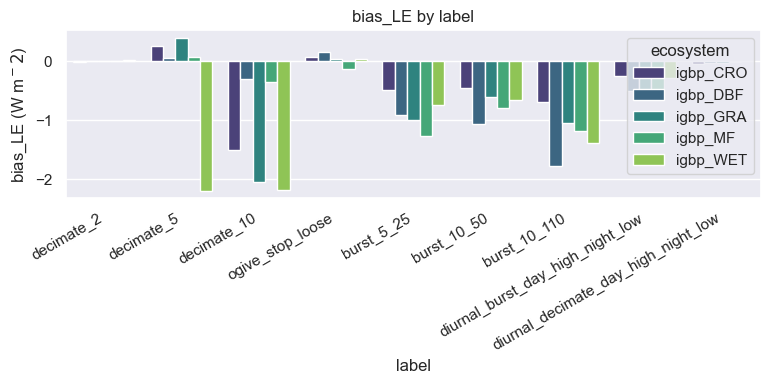

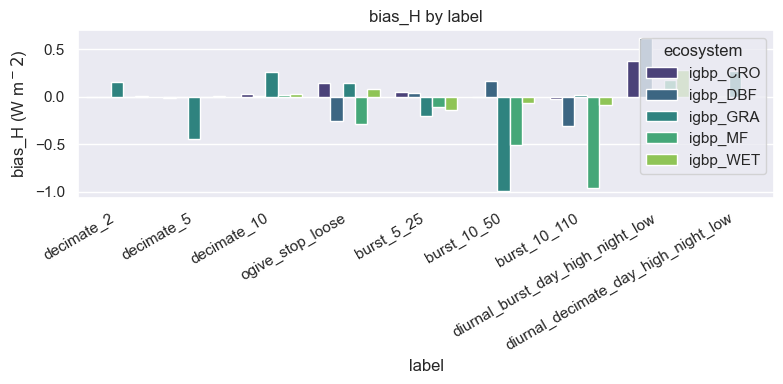

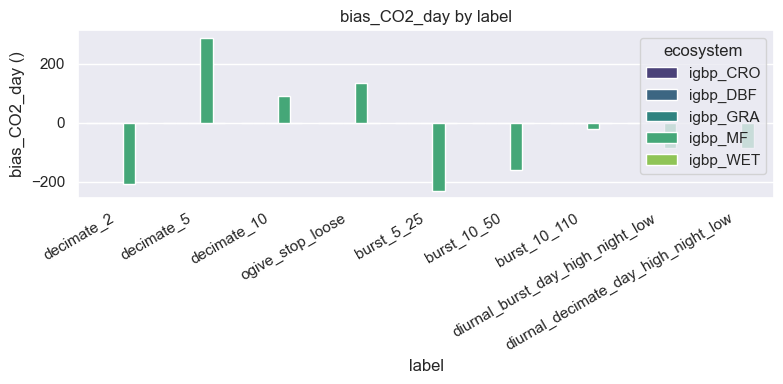

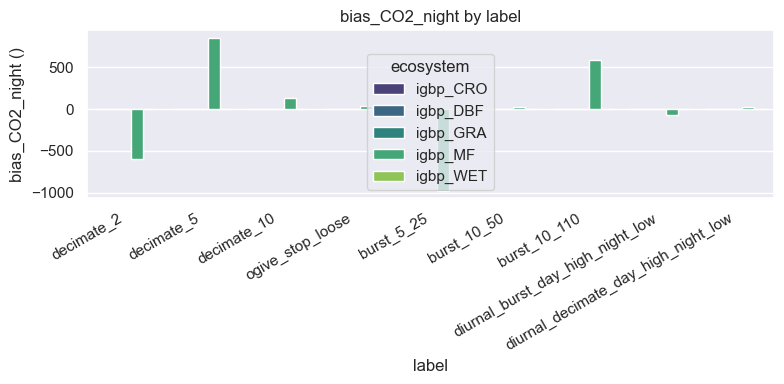

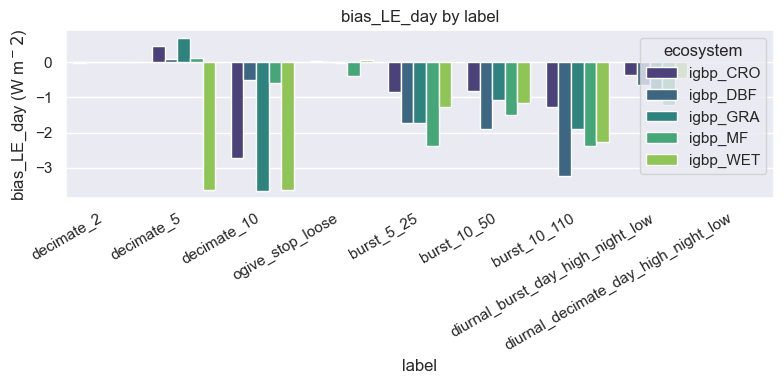

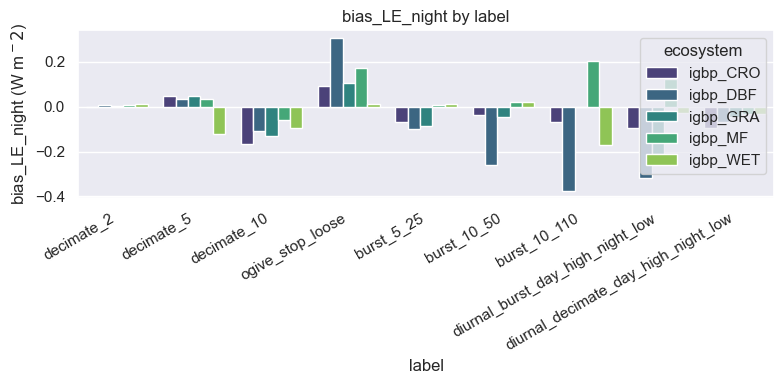

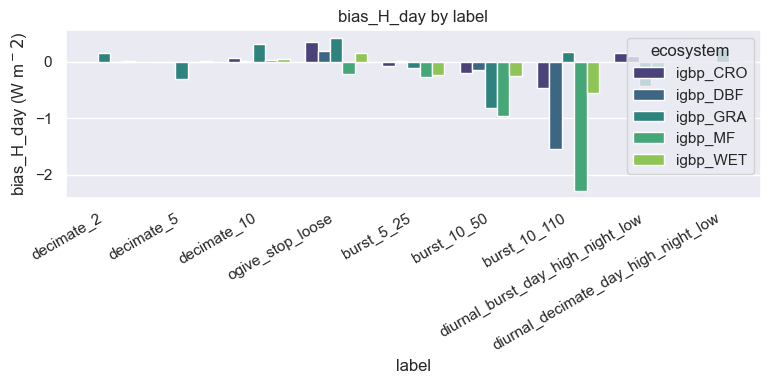

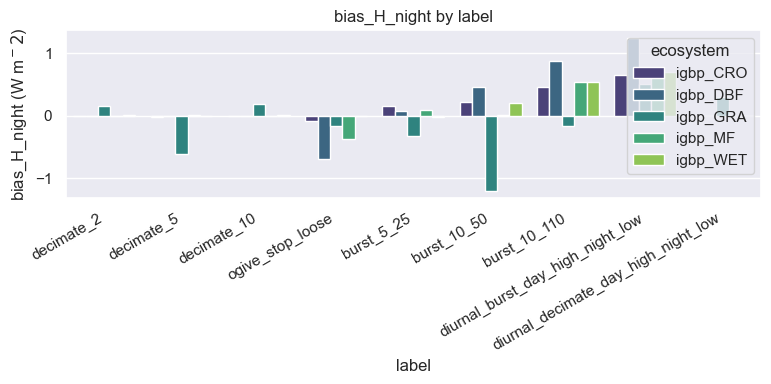

In [23]:
# Example bias plots
bias_bar("bias_CO2")
bias_bar("bias_LE")
bias_bar("bias_H")
bias_bar("bias_CO2_day")
bias_bar("bias_CO2_night")
bias_bar("bias_LE_day")
bias_bar("bias_LE_night")
bias_bar("bias_H_day")
bias_bar("bias_H_night")

In [25]:
og = df[df["label"].str.contains("ogive", case=False)]
display(og[["kept_fraction_mean","kept_fraction_std","kept_fraction_p10","kept_fraction_p50","kept_fraction_p90"]])

,kept_fraction_mean,kept_fraction_std,kept_fraction_p10,kept_fraction_p50,kept_fraction_p90
3,0.793784,0.263303,0.356092,1.000000,1.0
12,0.688060,0.274634,0.315511,0.682944,1.0
21,0.724279,0.286905,0.298556,0.812694,1.0
30,0.715544,0.281784,0.309556,0.764236,1.0
39,0.909609,0.182420,0.585678,1.000000,1.0


reg_slope_CO2  \
label                               ecosystem                  
burst_10_110                        igbp_CRO           0.970   
                                    igbp_DBF           0.959   
                                    igbp_GRA           0.967   
                                    igbp_MF            0.015   
                                    igbp_WET           0.950   
burst_10_50                         igbp_CRO           0.977   
                                    igbp_DBF           0.979   
                                    igbp_GRA           0.980   
                                    igbp_MF            0.411   
                                    igbp_WET           0.975   
burst_5_25                          igbp_CRO           0.980   
                                    igbp_DBF           0.976   
                                    igbp_GRA           0.962   
                                    igbp_MF            0.993   
                                    igbp_WET           0.975   
decimate_10                         igbp_CRO           0.951   
                                    igbp_DBF           0.995   
                                    igbp_GRA           0.934   
                                    igbp_MF            0.464   
                                    igbp_WET           0.964   
decimate_2                          igbp_CRO           1.000   
                                    igbp_DBF           1.000   
                                    igbp_GRA           1.000   
                                    igbp_MF            0.829   
                                    igbp_WET           1.000   
decimate_5                          igbp_CRO           0.994   
                                    igbp_DBF           1.000   
                                    igbp_GRA           0.993   
                                    igbp_MF            0.777   
                                    igbp_WET           0.965   
diurnal_burst_day_high_night_low    igbp_CRO           0.986   
                                    igbp_DBF           0.986   
                                    igbp_GRA           0.971   
                                    igbp_MF            0.709   
                                    igbp_WET           0.978   
diurnal_decimate_day_high_night_low igbp_CRO           0.994   
                                    igbp_DBF           0.999   
                                    igbp_GRA           0.985   
                                    igbp_MF            0.953   
                                    igbp_WET           0.991   
ogive_stop_loose                    igbp_CRO           1.004   
                                    igbp_DBF           0.994   
                                    igbp_GRA           1.004   
                                    igbp_MF            1.000   
                                    igbp_WET           1.000   

                                               reg_intercept_CO2  reg_r2_CO2  \
label                               ecosystem                                  
burst_10_110                        igbp_CRO               0.022       0.879   
                                    igbp_DBF              -0.029       0.881   
                                    igbp_GRA               0.088       0.869   
                                    igbp_MF               60.089       0.005   
                                    igbp_WET               0.056       0.618   
burst_10_50                         igbp_CRO              -0.010       0.942   
                                    igbp_DBF               0.000       0.949   
                                    igbp_GRA               0.048       0.939   
                                    igbp_MF              -21.633       0.213   
                                    igbp_WET               0.030       0.714   
burst_5_25                          igbp_CRO              -0.024       0.957  

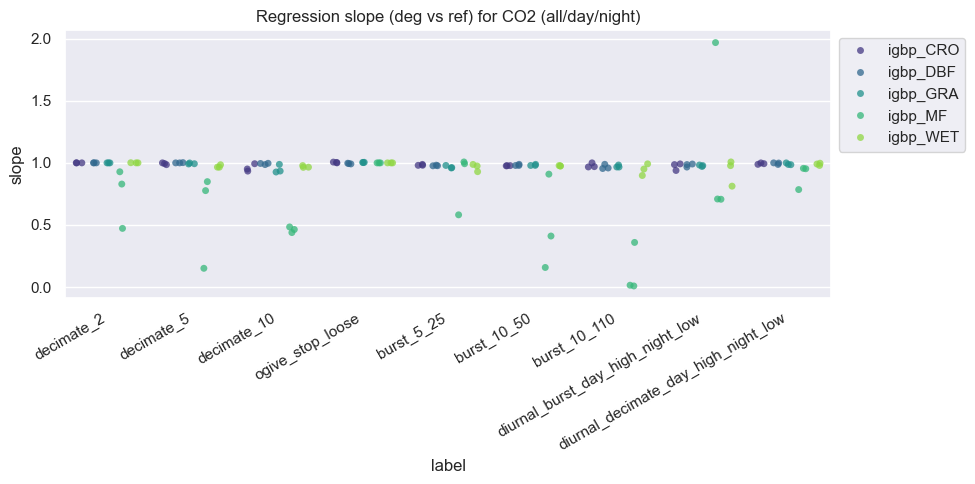

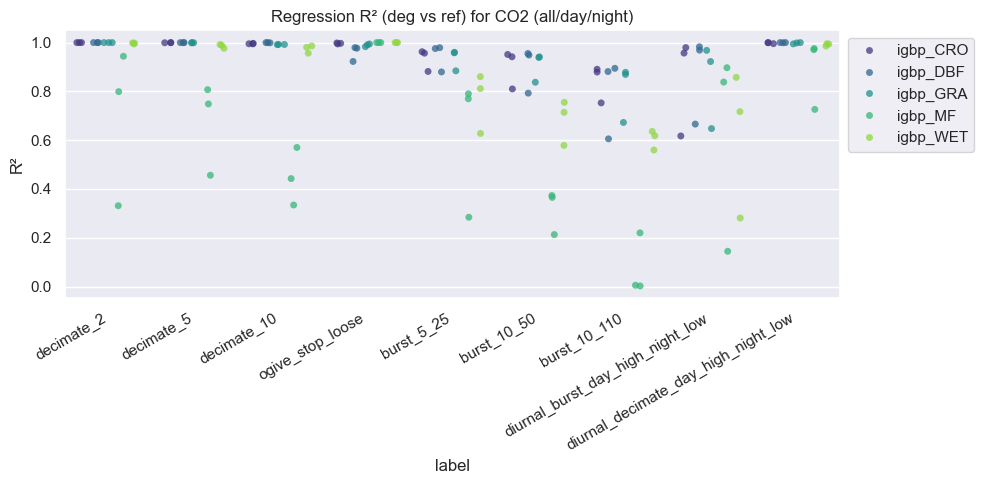

NameError: name 'rel_error_strip' is not defined

In [27]:
regression_table("CO2")          # table of mean slope/intercept/R² per label/ecosystem
regression_strip("CO2")          # jittered slopes and R², split all/day/night

rel_error_strip("rel_bias_CO2")               # relative bias
rel_error_strip("rel_random_error_CO2")       # relative random error
rel_error_strip("rel_bias_CO2_day")           # daytime bias
rel_error_strip("rel_random_error_CO2_night") # nighttime random error